# Activation

In [ ]:
def relu_cube(x):
    return torch.relu(x).pow(3)

# Preconditioner

## ReLU^3

In [ ]:
import torch
import numpy as np


def _fill_diagonal_(M: torch.Tensor, v: torch.Tensor, offset: int) -> None:
    """
    In-place helper that writes the 1-D tensor `v` to the diagonal of `M`
    indicated by `offset` (negative = below main, positive = above).
    """
    n = M.size(0)
    if offset >= 0:                        # super-diagonal
        rows = torch.arange(n - offset, device=M.device)
        cols = rows + offset
    else:                                  # sub-diagonal
        offset = -offset
        cols = torch.arange(n - offset, device=M.device)
        rows = cols + offset
    M[rows, cols] = v

def create_cube_matrix_torch(n: int,
                               *,
                               device=None,
                               dtype=torch.float32) -> torch.Tensor:
    """
    Construct the n×n banded matrix

        [ …  1 −4  6 −4  1 … ]

    with offsets −2, −1, 0, +1, +2 and values 1, −4, 6, −4, 1 respectively.
    Returns a *dense* tensor; call `.to_sparse()` afterwards if you want CSR/COO.
    """
    A = torch.zeros((n, n), device=device, dtype=dtype)

    specs = [
        ( torch.full((n - 2,),  1., device=device, dtype=dtype), -2 ),
        ( torch.full((n - 1,), -4., device=device, dtype=dtype), -1 ),
        ( torch.full((n,     ),  6., device=device, dtype=dtype),  0 ),
        ( torch.full((n - 1,), -4., device=device, dtype=dtype),  1 ),
        ( torch.full((n - 2,),  1., device=device, dtype=dtype),  2 ),
    ]

    for diag_vals, offset in specs:
        _fill_diagonal_(A, diag_vals, offset)

    return A

In [ ]:
# Example
if __name__ == "__main__":
    size = 10
    A = create_cube_matrix_torch(size)
    print(A)

tensor([[ 6., -4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-4.,  6., -4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -4.,  6., -4.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -4.,  6., -4.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -4.,  6., -4.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -4.,  6., -4.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -4.,  6., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -4.,  6., -4.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -4.,  6., -4.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -4.,  6.]])


## ReLU

In [ ]:
import torch
import numpy as np

def create_T_torch(m, device='cuda'):
    """Create a tridiagonal Toeplitz matrix on GPU with pattern [1, -2, 1]."""
    main_diag = -2 * torch.ones(m, device=device)
    upper_diag = torch.ones(m-1, device=device)
    lower_diag = torch.ones(m-1, device=device)

    T = torch.diag(main_diag, diagonal=0)
    T = T + torch.diag(upper_diag, diagonal=1)
    T = T + torch.diag(lower_diag, diagonal=-1)
    return T

def is_symmetric_positive_definite_torch(A, tol=1e-8):
    """Check if matrix is symmetric positive definite using PyTorch."""
    if not torch.allclose(A, A.T, atol=tol):
        return False
    try:
        torch.linalg.cholesky(A)
        return True
    except torch.linalg.LinAlgError:
        return False

# Target

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def u1(x):
    return x * (1 - x)

def u2(x):
    return np.sin(np.pi * x)

def u3(x):
    return x ** (2/3)

def u4(x):
    return np.tanh(100 * (x - 0.25))

def u5(x):
    return 5 * np.exp(-500 * (x - 0.75)**2) * np.sin(20 * np.pi * x)

def u6(x):
    return np.log(x+0.5)+0.1

def u7(x):
    return x - 0.5

# Init and plot

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# --------------- Initialization Functions --------------- #

def init_params_ones(width, left=0.0, right=1.0, device='cuda'):
    """Initialize parameters as flat tensor on specified device."""
    W1 = torch.ones(width, device=device)
    b1 = torch.linspace(left, right, width, device=device)
    W2 = torch.ones(width, device=device)
    b2 = torch.ones(1, device=device)
    flat_params = torch.cat([p.flatten() for p in (W1, b1, W2, b2)])
    flat_params.requires_grad_(True)
    return flat_params

def init_params_kaiming(width, device='cuda'):
    """Kaiming-uniform style initialization, same as PyTorch nn.Linear default."""
    # fc1: input_dim -> hidden_dim1
    bound1 = 1.0 / np.sqrt(width)
    W1 = torch.empty(width, device=device).uniform_(-bound1, bound1)
    b1 = torch.empty(width, device=device).uniform_(-bound1, bound1)

    # fc2: hidden_dim1 -> hidden_dim2
    bound2 = 1.0 / np.sqrt(width)
    W2 = torch.empty(width, device=device).uniform_(-bound2, bound2)
    b2 = torch.empty(1, device=device).uniform_(-bound2, bound2)

    flat_params = torch.cat([p.flatten() for p in (W1, b1, W2, b2)])
    flat_params.requires_grad_(True)
    return flat_params


# --------------- Plot Functions --------------- #

def plot_training_loss(loss_history):
    """Plot training loss curve."""
    plt.figure(figsize=(5, 3))
    plt.plot(np.log(loss_history), label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss (MSE)')
    plt.title('Training Loss History')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_approximation(model, true_function, device='cuda'):
    """Plot model approximation vs true function."""
    # Generate test points
    X_test = torch.linspace(0, 1, 1000, device=device).unsqueeze(1)

    # Create predictions
    with torch.no_grad():
        y_pred = model.forward(X_test, model.theta, T)

    # Move to CPU for plotting
    X_test_cpu = X_test.cpu().numpy()
    y_pred_cpu = y_pred.cpu().numpy()

    # True function values
    y_true = true_function(X_test_cpu)

    # Create plot
    plt.figure(figsize=(5, 3))
    plt.plot(X_test_cpu, y_true, label='True Function', linestyle='--')
    plt.plot(X_test_cpu, y_pred_cpu, label='Model Approximation')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Function Approximation')
    plt.legend()
    plt.grid(True)

    plt.show()

# Model

In [ ]:
# --------------- Model Class --------------- #

# Modified PreconditionedNetwork class with visualization support
class PreconditionedNetwork:
    def __init__(self, width,
                 left=0, right=1, activation=relu_cube,
                 init_method='ones', device='cuda'):
        self.width = width
        self.activation = activation
        self.device = device

        if init_method == 'ones':
            self.theta = init_params_ones(
                width, left, right, device
            )
        elif init_method == 'kaiming':
            self.theta = init_params_kaiming(
                width, device
            )
        else:
            raise ValueError("Invalid initialization method.")

    def unflatten_params(self, theta):
        sizes = [
            self.width,  # W1
            self.width,                  # b1
            self.width, # W2
            1,
        ]
        params = []
        ptr = 0
        for size in sizes:
            params.append(theta[ptr:ptr+size])
            ptr += size

        W1 = params[0]
        b1 = params[1]
        W2 = params[2]
        b2 = params[3]

        return W1, b1, W2, b2

    def forward(self, X, theta, T):
        W1, b1, W2, b2 = self.unflatten_params(theta)

        Z1 = X.unsqueeze(1) @ W1.unsqueeze(0) + b1
        # print((X.unsqueeze(1) @ W1.unsqueeze(0)).shape)
        # print(Z1.shape)
        A1 = self.activation(Z1)
        # print(A1.shape)
        A1_pre = A1 @ T.T
        # print(A1_pre.shape)

        Z2 = A1_pre @ W2 + b2

        # print('X.shape', str(X.shape))
        # print('W1.shape', str(W1.shape))
        # print('b1.shape', str(b1.shape))
        # print('Z1.shape', str(Z1.shape))
        # print('A1.shape', str(A1.shape))
        # print('A1_pre.shape', str(A1_pre.shape))
        # print('W2.shape', str(W2.shape))
        # print('b2.shape', str(b2.shape))
        # print('Z2.shape', str(Z2.shape))

        return Z2  #one-d shape

    def compute_loss(self, X, y, theta, T):
        y_pred = self.forward(X, theta, T)

        # Ensure matching dimensions if output_dim=1
        if y_pred.dim() != 1:
            raise ValueError("Output dimension should be 1.")

        return F.mse_loss(y_pred, y)

    def train(self, X, y, T, lr=0.01, max_iter=1000, tol=1e-6):
        theta = self.theta

        # T = T.to(self.device) if isinstance(T, torch.Tensor) else torch.tensor(T, device=self.device
        # try:
        #     T_inv = torch.linalg.inv(T.float())
        # except:
        #     T += 1e-6 * torch.eye(T.size(0), device=self.device)
        #     T_inv = torch.linalg.inv(T.float())


        loss_history = []
        prev_theta = theta.clone().detach()

        for _ in range(max_iter):
            if theta.grad is not None:
                theta.grad.zero_()

            loss = self.compute_loss(X, y, theta, T)
            loss_history.append(loss.item())

            loss.backward()
            g = theta.grad

            with torch.no_grad():
                theta -= lr * g

            if torch.norm(theta - prev_theta) < tol:
                self.theta = theta.detach().requires_grad_(True)
                break
            prev_theta = theta.clone().detach()

        self.theta = theta.detach().requires_grad_(True)
        return loss_history

# check

In [ ]:
# ------------------ Example Usage ------------------ #

# Example usage with visualization
if __name__ == "__main__":
    # Configuration
    width = 10
    m = 200

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Define true function (example: sine wave)
    def target(x):
        # print(np.sin(2 * np.pi * x).shape)
        return np.sin(2 * np.pi * x)

    # Generate data
    X_np = np.random.uniform(0, 1, m)
    y_np = u1(X_np)

    # Convert to tensors
    X = torch.tensor(X_np, dtype=torch.float32, device=device)
    # print(X.shape)
    y = torch.tensor(y_np, dtype=torch.float32, device=device)

    # Initialize network and preconditioner
    net_test = PreconditionedNetwork(
        width = width,
        activation= relu_cube,
        device=device
    )

    # No need for a preconditioner
    total_params = 3 * width + 1
    I = torch.eye(width, device=device)

    # Train network
    theta = init_params_ones(
                width = width, left = 0, right = 1, device = 'cuda'
            )
    forward_output = net_test.forward(X, theta=theta, T=I)


# Expreiments

/tmp/ipython-input-2871816135.py:42: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(loss_history), label='Training Loss')


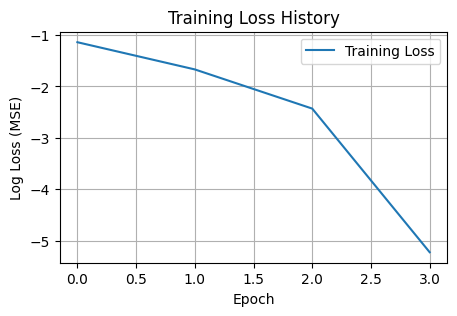

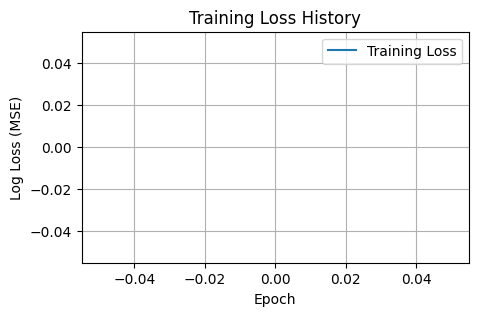

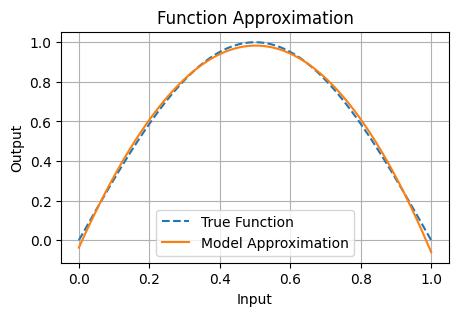

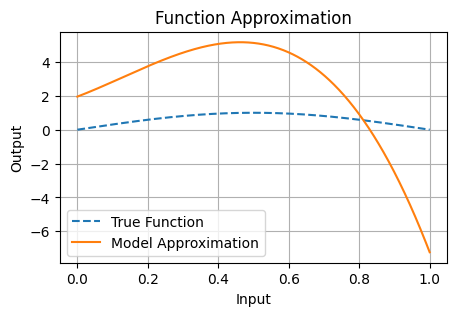

In [ ]:
if __name__ == "__main__":
    # Configuration
    target = u2
    lr = 0.01
    width = 10
    m = 300
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Preconditioner
    T = create_cube_matrix_torch(width, device=device)
    I = torch.eye(width, device=device)
    # Data
    X_np = np.random.uniform(0, 1, m)
    y_np = target(X_np)
    X = torch.tensor(X_np, dtype=torch.float32, device=device)
    y = torch.tensor(y_np, dtype=torch.float32, device=device)
    # Nets
    net_pre = PreconditionedNetwork(
        width = width,
        activation= relu_cube,
        init_method='kaiming',
        device=device
    )
    net_no_pre = PreconditionedNetwork(
        width = width,
        activation= relu_cube,
        init_method='kaiming',
        device=device
    )
    # Training
    loss_history_pre = net_pre.train(X, y, T, lr=lr, max_iter=20000, tol=1e-6)
    loss_history_no_pre = net_no_pre.train(X, y, I, lr=lr, max_iter=20000, tol=1e-6)
    # Visualize
    plot_training_loss(np.log(loss_history_pre))
    plot_training_loss(np.log(loss_history_no_pre))
    plot_approximation(net_pre, target, device=device)
    plot_approximation(net_no_pre, target, device=device)


# The LOOPs

Pre/no-pre only:   0%|          | 0/4 [00:00<?, ?it/s]

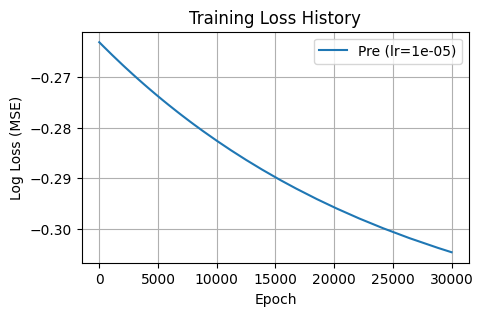

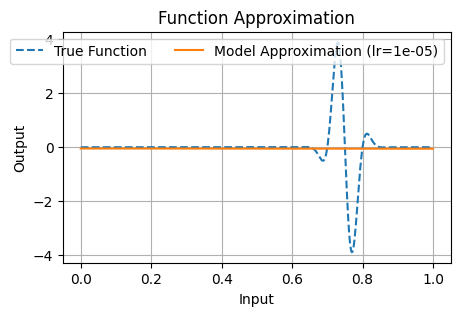

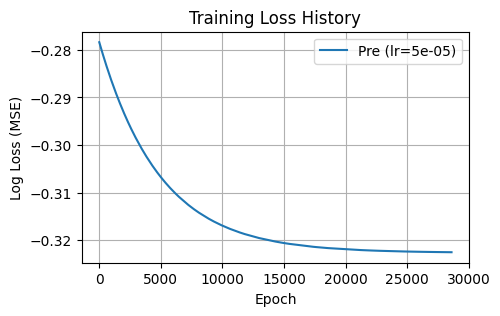

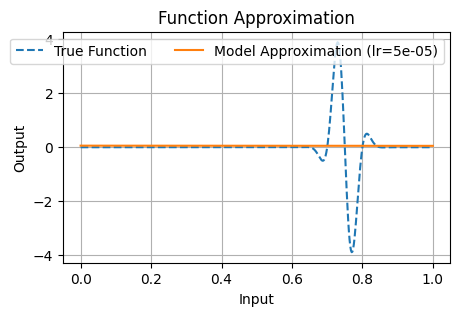

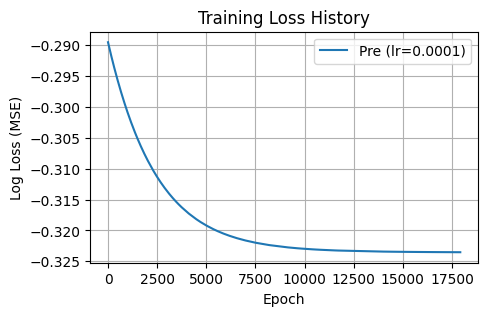

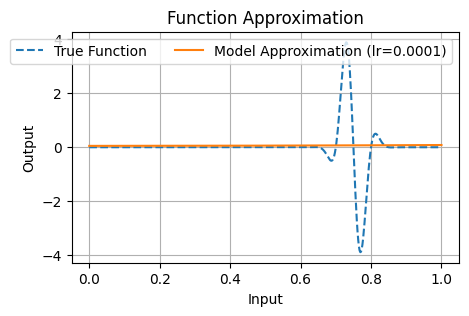

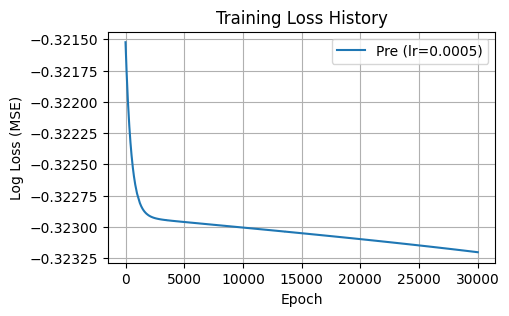

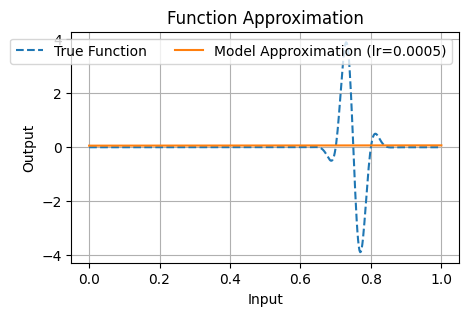

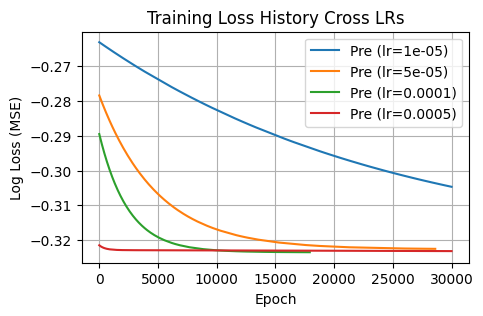

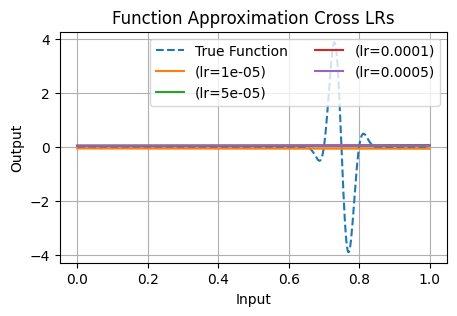

In [ ]:
from tqdm.auto import tqdm

if __name__ == "__main__":
    # Configuration
    target = u5
    lr_grid = [1e-5, 5e-5, 1e-4, 5e-4]
    # lr_grid = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
    width = 50
    m = 500
    max = 30000
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    base_seed = 42
    # Preconditioner
    T = create_cube_matrix_torch(width, device=device)
    I = torch.eye(width, device=device)
    # Starting Point
    starting_point = 'kaiming'

    preconditioner = T  ##################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# ------------------ DATA (fixed across LRs) ------------------ #
    rng = np.random.default_rng(seed=42)
    X_np = np.random.uniform(0, 1, m)
    y_np = target(X_np)
    X = torch.tensor(X_np, dtype=torch.float32, device=device)
    y = torch.tensor(y_np, dtype=torch.float32, device=device)


    X_test = torch.linspace(0, 1, 500, device=device).unsqueeze(1)
    y_true = target(X_test.cpu().numpy())
# ------------------------------------------------------------- #
    def make_net():
        return PreconditionedNetwork(
            width = width,
            activation= relu_cube,
            init_method= starting_point,
            device=device
        )

    all_loss_histories = []
    all_final_pred = []

    # Sweep ---------------------------------------------------- #
    for i, lr in enumerate(tqdm(lr_grid, desc = "Pre/no-pre only")):
        seed = base_seed
        net_i = make_net()

        loss_history_i = net_i.train(X, y, preconditioner, lr=lr, max_iter=max, tol=1e-6)
        all_loss_histories.append((float(lr), np.asarray(loss_history_i, dtype=float)))

        # Plot Loss Curve
        plt.figure(figsize=(5, 3))
        plt.plot(np.log(loss_history_i), label=f'Pre (lr={lr:.3g})')
        plt.xlabel('Epoch')
        plt.ylabel('Log Loss (MSE)')
        plt.title('Training Loss History')
        plt.legend()
        plt.grid(True)

        # Plot approximation
        with torch.no_grad():
            y_pred = net_i.forward(X_test, net_i.theta, preconditioner).cpu().numpy()
        all_final_pred.append((float(lr), y_pred))

        plt.figure(figsize=(5, 3))
        X_test_cpu = X_test.cpu().numpy()
        plt.plot(X_test_cpu, y_true, label='True Function', linestyle='--')
        plt.plot(X_test_cpu, y_pred, label=f'Model Approximation (lr={lr:.3g})')
        plt.xlabel('Input')
        plt.ylabel('Output')
        plt.title('Function Approximation')
        plt.legend(ncol=2)
        plt.grid(True)
        plt.show()

# -------- overall ---------------------------------------------------- #
figA = plt.figure(figsize=(5, 3))
for lr, hist in all_loss_histories:
    plt.plot(np.log(hist), label=f'Pre (lr={lr:.3g})')
plt.xlabel('Epoch')
plt.ylabel('Log Loss (MSE)')
plt.title('Training Loss History Cross LRs')
plt.legend()
plt.grid(True)
plt.show()


figB = plt.figure(figsize=(5, 3))
X_test_cpu = X_test.cpu().numpy()
plt.plot(X_test_cpu, y_true, label='True Function', linestyle='--')
for lr, pred in all_final_pred:
    plt.plot(X_test_cpu, pred, label=f'(lr={lr:.3g})')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Function Approximation Cross LRs')
plt.legend(ncol=2)
plt.grid(True)
plt.show()








# PINN with SHALLOW NN

### See PINN file